# Traced Dynamic Categories - Brown and Spivak
This notebook accompanies the paper "Traced Dynamic Categories".

There are two demos, an agent-based model (using the Maybe monad) and 
a probabalistic graphical program using the Dist monad.

## Lotka Volterra model


Our goal is to construct a program which performs a simulation akin to the 
Netlogo model [Wolf Sheep Predation](http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation).


### Setup 

The first step in working with ACSets is to pick a schema. We will model the 
state of the world with the following schema:

<img src="assets/schema.png" alt="schema" width=300/>

Sheep and Wolves both have energy, direction, and a position. Edges also have directions.
Whether or not a vertex has grass growing on it is also indicated with an "Energy", 
the meaning of which is that when `grass_eng=0` there is grass present, and when 
`grass_eng=n` there are `n` timesteps left until the grass grows back.

  Activating project at `~/code/AlgebraicRewriting.jl/docs`
[ Info: Precompiling Catlab [134e5e36-593f-5add-ad60-77f754baafbe]


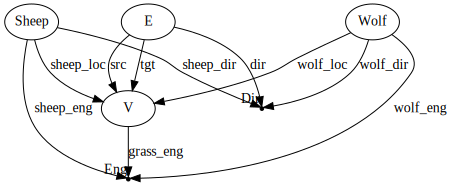

In [1]:
using Pkg; 
Pkg.activate("..")
using Revise, Random, Test, StructEquality
using Catlab, Catlab.CategoricalAlgebra, Catlab.Graphs, Catlab.Graphics
Random.seed!(123);

@present SchLV <: SchGraph begin
  (Sheep,Wolf)::Ob
  sheep_loc::Hom(Sheep, V)
  wolf_loc::Hom(Wolf, V)

  (Dir,Eng)::AttrType
  grass_eng::Attr(V, Eng)
  sheep_eng::Attr(Sheep, Eng)
  wolf_eng::Attr(Wolf, Eng)
  sheep_dir::Attr(Sheep, Dir)
  wolf_dir::Attr(Wolf, Dir)
  dir::Attr(E, Dir)
end;
to_graphviz(SchLV; prog="dot")

We also want an extension of this schema which includes coordinates on the vertices, for visualization.

In [2]:
@present SchLV′ <: SchLV begin
  Coord::AttrType 
  coord::Attr(V,Coord)
end;

ACSet schemas also require concrete Julia types for the schema's AttrTypes. We can use the standard integer for `Eng`, but our `Dir` type is something that can be custom-made. It should have four cardinal directions and a notion of which direction is to the left/right of another.

In [3]:
import Catlab.CategoricalAlgebra: left, right

abstract type Direction end 
@struct_hash_equal struct North <: Direction end 
@struct_hash_equal struct South <: Direction end 
@struct_hash_equal struct East <: Direction end 
@struct_hash_equal struct West <: Direction end 
show(io,::North) = show(io, :N); show(io,::South) = show(io, :S)
show(io,::East) = show(io, :E); show(io,::West) = show(io, :W)
right(::North) = East(); right(::East) = South(); 
right(::South) = West(); right(::West) = North()
left(::North) = West(); left(::East) = North()
left(::South) = East(); left(::West) = South()


@acset_type LV_Generic(SchLV) <: HasGraph
const LV = LV_Generic{Direction, Int}

@acset_type LV′_Generic(SchLV′) <: HasGraph
const LV′ = LV′_Generic{Direction, Int, Tuple{Int,Int}};

There are some relationships between these schemas which we can codify with 
functors. Furthermore, we can use these functors to perform useful data 
migration! For example, there is an endofunctor on `SchLV` that swaps wolf-things
and sheep-things via $\Delta$ migration.

In [4]:
using AlgebraicRewriting
Swap = Migrate(
  Dict(:Sheep=>:Wolf, :Wolf=>:Sheep), 
  Dict([:sheep_loc=>:wolf_loc, :wolf_loc=>:sheep_loc,
        :sheep_eng=>:wolf_eng, :wolf_eng=>:sheep_eng,:grass_eng =>:grass_eng,
        :sheep_dir=>:wolf_dir, :wolf_dir=>:sheep_dir,]), LV);

[ Info: Precompiling AlgebraicRewriting [725a01d3-f174-5bbd-84e1-b9417bad95d9]


There is also a functor $SchLV \hookrightarrow SchLV\_with\_coordinates$ which 
will be used for $\Sigma$ migration.

In [5]:
Coords = Migrate(
  Dict(x=>x for x in Symbol.(SchLV.generators[:Ob])), 
  Dict(x=>x for x in Symbol.(SchLV.generators[:Hom])), 
  LV′; delta=false);

We now write a function which initializes a n x n grid to serve as our initial simulation input. 

In [6]:
function create_grid(n::Int)
  lv = LV′()
  coords = Dict()
  # Initialize grass 50% green, 50% uniformly between 0-30
  for i in 0:n-1
    for j in 0:n-1
      coords[i=>j] = add_part!(lv, :V; grass_eng=max(0,rand(-30:30)), coord=(i,j))
    end
  end
  for i in 0:n-1
    for j in 0:n-1
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[mod(i+1,n)=>j], dir=East())
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[mod(i-1,n)=>j], dir=West())
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[i=>mod(j+1,n)], dir=North())
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[i=>mod(j-1,n)], dir=South())
    end
  end
  return lv
end

"""
`n` is the length of the grid.
`sheep` and `wolves` are the fraction of spaces that are 
populated with that animal
"""
function initialize(n::Int, sheep::Float64, wolves::Float64)::LV′
  grid = create_grid(n)
  args = [(sheep, :Sheep, :sheep_loc, :sheep_eng, :sheep_dir),
          (wolves, :Wolf, :wolf_loc, :wolf_eng, :wolf_dir)]
  for (n_, name, loc, eng, d) in args
    for _ in 1:round(Int,n_*n^2)
      dic = Dict([eng => 5, loc => rand(vertices(grid)),
                  d => rand([North(),East(),South(),West()])])
      add_part!(grid, name; dic...)
    end
  end
  return grid
end
        
X = initialize(2, 0.5,0.5)

LV′ with elements V = 1:4, E = 1:16, Sheep = 1:2, Wolf = 1:2, Dir = 1:0, Eng = 1:0, Coord = 1:0
┌───┬───────────┬────────┐
│ V │ grass_eng │  coord │
├───┼───────────┼────────┤
│ 1 │         0 │ (0, 0) │
│ 2 │        29 │ (0, 1) │
│ 3 │        23 │ (1, 0) │
│ 4 │         0 │ (1, 1) │
└───┴───────────┴────────┘
┌────┬─────┬─────┬─────────┐
│  E │ src │ tgt │     dir │
├────┼─────┼─────┼─────────┤
│  1 │   1 │   3 │  East() │
│  2 │   1 │   3 │  West() │
│  3 │   1 │   2 │ North() │
│  4 │   1 │   2 │ South() │
│  5 │   2 │   4 │  East() │
│  6 │   2 │   4 │  West() │
│  7 │   2 │   1 │ North() │
│  8 │   2 │   1 │ South() │
│  9 │   3 │   1 │  East() │
│ 10 │   3 │   1 │  West() │
│ 11 │   3 │   4 │ North() │
│ 12 │   3 │   4 │ South() │
│ 13 │   4 │   2 │  East() │
│ 14 │   4 │   2 │  West() │
│ 15 │   4 │   3 │ North() │
│ 16 │   4 │   3 │ South() │
└────┴─────┴─────┴─────────┘
┌───────┬───────────┬───────────┬───────────┐
│ Sheep │ sheep_loc │ sheep_eng │ sheep_dir │
├───────┼───────────┼───────────┼───────────┤
│     1 │         2 │         5 │   North() │
│     2 │         1 │         5 │    East() │
└───────┴───────────┴───────────┴───────────┘
┌──────┬──────────┬──────────┬──────────┐
│ Wolf │ wolf_loc │ wolf_eng │ wolf_dir │
├──────┼──────────┼──────────┼──────────┤
│    1 │        2 │        5 │  South() │
│    2 │        1 │        5 │  North() │
└──────┴──────────┴──────────┴──────────┘

Now we need a function to properly visualize grid-like graphs. Green dots are vertices with grass, red squares are wolves, blue squares are sheep, and their energy is indicated by an integer. The direction being faced is indicated by position on the vertex. 

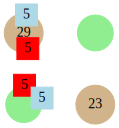

In [7]:

using Catlab.Graphics.Graphviz: Attributes, Statement, Node, Digraph
using Catlab.Graphics.Graphviz

function view_LV(p::LV′; name="G", title="", star=nothing)
  pstr = ["$(i),$(j)!" for (i,j) in p[:coord]]
  stmts = Statement[]
    for s in 1:nv(p)
      st = (star == (:V=>s)) ? "*" : ""
      gv = p[s, :grass_eng]
      col = gv  == 0 ? "lightgreen" : "tan"
      push!(stmts,Node("v$s", Attributes(
                  :label=>gv == 0 ? "" : string(gv)*st,
                  :shape=>"circle", :color=> col, :pos=>pstr[s])))
    end
  d = Dict([East()=>(1,0),North()=>(0,1), South()=>(0,-1),West()=>(-1,0),])

  args = [(:true,:Wolf,:wolf_loc,:wolf_eng,:wolf_dir),
          (false, :Sheep, :sheep_loc, :sheep_eng,:sheep_dir)]

  for (is_wolf, prt, loc, eng, dr) in args
    for w in parts(p, prt)
      st = (star == ((is_wolf ? :Wolf : :Sheep) => w)) ? "*" : ""
      e = only(incident(p,p[w,loc], :src) ∩ incident(p,p[w,dr], :dir))
      s = src(p,e)
      dx, dy = d[p[e, :dir]]
      (sx,sy) = p[s,:coord]

      L, R = 0.25, 0.1
      wx = sx+L*dx+R*rand()
      wy = sy+L*dy+R*rand()
      ID = "$(is_wolf ? :w : :s)$w"
      append!(stmts,[Node(ID, Attributes(
        :label=>"$(p[w,eng])"*st,
        :shape=>"square", :width=>"0.3px", :height=>"0.3px", :fixedsize=>"true",
        :pos=>"$(wx),$(wy)!",:color=> is_wolf ? "red" : "lightblue"))])
    end
  end

  g = Graphviz.Digraph(name, Statement[stmts...]; prog="neato",
        graph_attrs=Attributes(:label=>title, :labelloc=>"t"),
        node_attrs=Attributes(:shape=>"plain", :style=>"filled"))
  return g
end

view_LV(X)


If we have a wolf/sheep/vertex shaped agent, we want to be able to show this 
fact visually, too. 

The following example shows when a wolf is distinguished.

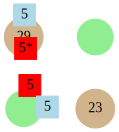

In [8]:
const Var = AttrVar # shorthand
Base.isless(x::Var,y::Var) = x.val < y.val

"""Visualize a LV with a distinguished focus"""
function view_LV(p::ACSetTransformation; name="G", title="")
  if nparts(dom(p),:Wolf) == 1 
    star = :Wolf=>p[:Wolf](1)
  elseif nparts(dom(p),:Sheep) == 1 
    star = :Sheep=>p[:Sheep](1)
  elseif nparts(dom(p),:V) == 1 
    star = :V=>p[:V](1)
  else
    star = nothing
  end
  view_LV(codom(p); name=name, title=title, star=star)
end

# Empty agent type
I = LV()
# Generic sheep agent
S = @acset LV begin
  Sheep=1; V=1; Dir=1; Eng=2; sheep_loc=1; grass_eng=[AttrVar(1)]
  sheep_dir=[AttrVar(1)]; sheep_eng=[AttrVar(2)]; 
end
# Generic wolf agent
W = Swap(S)
# Generic grass agent
G = @acset LV begin V=1; Eng=1; grass_eng=[AttrVar(1)] end

N = Dict(W=>"W",S=>"S",G=>"G", I=>"") # names for visualization


view_LV(homomorphism(Coords(W), X)) # a distinguished wolf 

### Defining the rewrite rules 
We are now ready to begin constructing rewrite rules! 

We start with rotation of Sheep. This requires no change of combinatorial data, only a function 
applied to the value of the bound `Dir` variable in our generic sheep, `S`.

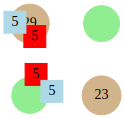

In [9]:
rl = Rule(id(S),id(S); expr=(Dir=[xs->left(only(xs))],))
rr = Rule(id(S),id(S); expr=(Dir=[xs->right(only(xs))],));

view_LV(rewrite(Coords(rl), X)) # a sheep has rotated left 

We want to wrap these rewrite rules into a primitive generator for programs, `RuleApp`. 

We want this rule to occur in the context of a sheep agent (the rule means, "*this* sheep turns", not "*some arbitrary* sheep turns"), so the `RuleApp` takes a parameter for the shape of the agent (Catlab automatically deduces the maps $S \rightarrow L$ and $S \rightarrow R$ for the rewrite rule because there is only one choice, which is the identity map).

Furthermore, this isn't a rule that can conceivable fail to match, so we don't really need to distinguish between the two outgoing ports of the `RuleApp` box, so we merge them together (which is the effect of calling `tryrule` on a `RuleApp`. 

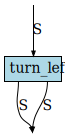

In [10]:
sheep_rotate_l = tryrule(RuleApp(:turn_left, rl, S))
sheep_rotate_r = tryrule(RuleApp(:turn_right, rr, S))

view_sched(sheep_rotate_l; names=N)

Now we treat sheep moving forward, which comes with an energy cost of $1$. Again we use `tryrule`. This time, we explicitly provide maps $S \rightarrow L$ and $S\rightarrow R$ to relate the sheep agent to the input and output of the rewrite rule.

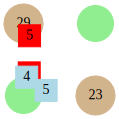

In [11]:
s_fwd_l = @acset LV begin
  Sheep=1; V=2; E=1; sheep_loc=1; Dir=1; Eng=3
  src=1; tgt=2; dir=[AttrVar(1)]; 
  grass_eng=AttrVar.(1:2)
  sheep_dir=[AttrVar(1)]; sheep_eng=[AttrVar(3)]
end

s_fwd_i = deepcopy(s_fwd_l)
rem_part!(s_fwd_i, :Sheep, 1); 
rem_part!(s_fwd_i, :Eng, 3)

s_fwd_r = deepcopy(s_fwd_l)
s_fwd_r[1, :sheep_loc] = 2

s_n = deepcopy(s_fwd_l)
set_subpart!(s_n, 1, :sheep_eng, 0); 
rem_part!(s_n, :Eng, 3)

sheep_fwd_rule = Rule(
  homomorphism(s_fwd_i, s_fwd_l; monic=true),
  homomorphism(s_fwd_i, s_fwd_r; monic=true),
  ac=[AppCond(homomorphism(s_fwd_l, s_n), false)],
  expr=(Eng=[vs->vs[1], vs->vs[2], vs->vs[3]-1],)
)

sheep_fwd = tryrule(RuleApp(:move_fwd, sheep_fwd_rule, 
  homomorphism(S,s_fwd_l), homomorphism(S,s_fwd_r)))

view_LV(rewrite(Coords(sheep_fwd_rule), X))

Next we consider a sheep eating grass. Our pattern is a sheep on a vertex. A positive application 
condition ensures that grass is present on the vertex for the rewrite to be 
applicable. The sheep gains 4 energy units.

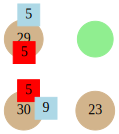

In [12]:


# Eat grass + 4eng
#-----------------
# Grass is at 0 - meaning it's ready to be eaten
s_eat_pac = @acset LV begin
  Sheep=1; Eng=1; Dir=1; V=1; sheep_loc=1; 
  grass_eng=[0]; sheep_eng=[AttrVar(1)]; sheep_dir=[AttrVar(1)]
end


se_rule = Rule(id(S), id(S); expr=(Eng=[vs->30,vs->vs[2]+4],), 
               ac=[AppCond(homomorphism(S,s_eat_pac))])
sheep_eat = tryrule(RuleApp(:Sheep_eat, se_rule, S))
view_LV(rewrite(Coords(se_rule), X))

Now for wolves eating sheep who are on the same vertex. This gives them +20 energy. 

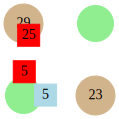

In [13]:
w_eat_l = @acset LV begin
  Sheep=1; Wolf=1; V=1; Eng=3; Dir=2; grass_eng=[AttrVar(1)]
  sheep_dir=[AttrVar(1)]; wolf_dir=[AttrVar(2)]; 
  sheep_eng=[AttrVar(2)]; wolf_eng=[AttrVar(3)]
  sheep_loc=1; wolf_loc=1
end

w_eat_r = @acset LV begin
  Wolf=1; V=1; Eng=2; Dir=1; grass_eng=[AttrVar(1)]
  wolf_dir=[AttrVar(1)]; wolf_eng=[AttrVar(2)]; wolf_loc=1
end

we_rule = Rule(homomorphism(w_eat_r, w_eat_l), id(w_eat_r); 
               expr=(Eng=[vs->vs[1],vs->vs[3]+20],))
wolf_eat = tryrule(RuleApp(:Wolf_eat, we_rule, W))
        
view_LV(rewrite(Coords(we_rule), X))

Starvation at $0$ energy is our first example of a rewrite rule which has a different agent type for its input and output (as the current agent being focused on is removed from the model). The output agent for a successful rewrite rule is an empty agent. 

If we wish to merge together the output wires of the rule application, we get a type checking error! We have to postcompose the 'unsuccessful match' branch (which has the same agent type as the input, i.e. sheep) with a forgetful `Weaken` box in order to do this.

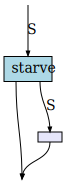

In [14]:

# Die if 0 eng
#-------------
s_die_l = @acset LV begin
  Sheep=1; V=1; Eng=1; Dir=1; grass_eng=[AttrVar(1)]
  sheep_eng=[0]; sheep_loc=1; sheep_dir=[AttrVar(1)]
end
sheep_die_rule = Rule(homomorphism(G, s_die_l), id(G))
sheep_starve = (RuleApp(:starve, sheep_die_rule, 
                       homomorphism(S,s_die_l), create(G))
                ⋅ (id([I]) ⊗ Weaken(create(S))) ⋅ merge_wires(I))

view_sched(sheep_starve; names=N)

Now we treat reproduction of sheep. A new sheep is created, and energy is split between the two sheep (rounding up if it is initially odd).

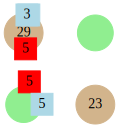

In [15]:
s_reprod_r =  @acset LV begin
  Sheep=2; V=1; Eng=3; Dir=2; sheep_loc=1; grass_eng=[AttrVar(1)]
  sheep_dir=AttrVar.(1:2); sheep_eng=AttrVar.(2:3); 
end

sheep_reprod_rule = Rule(
  homomorphism(G, S),
  homomorphism(G, s_reprod_r); 
  expr=(Dir=[vs->vs[1],vs->vs[1]], Eng=[vs->vs[1], 
             fill(vs->round(Int, vs[2]/2, RoundUp), 2)...],)
  )

sheep_reprod = RuleApp(:reproduce, sheep_reprod_rule, 
                       id(S), homomorphism(S, s_reprod_r)) |> tryrule

view_LV(rewrite(Coords(sheep_reprod_rule), X))

Lastly we decrement the grass counter if it's not zero.

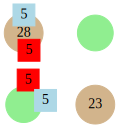

In [16]:

g_inc_n = deepcopy(G)
set_subpart!(g_inc_n,1, :grass_eng, 0); 
rem_part!(g_inc_n, :Eng, 1)

g_inc_rule = Rule(id(G), id(G);
                  ac=[AppCond(homomorphism(G, g_inc_n), false)],
                  expr=(Eng=[vs->only(vs)-1],))
g_inc = RuleApp(:GrassIncrements,g_inc_rule, G) |> tryrule
view_LV(rewrite(Coords(g_inc_rule), X))

### Assembling a program from the rules
Recognizing there is a commonality between the day in the life of a sheep and a wolf, we have only defined certain rules for sheep and will use `Swap` to turn them into wolf rules. We first assemble the common part of the day into a program and then use `Swap` on that program.

This assembly uses the `mk_sched` function which allows for a programming-like syntax (between the `quote ... end`, below) to specify the control flow of a program.

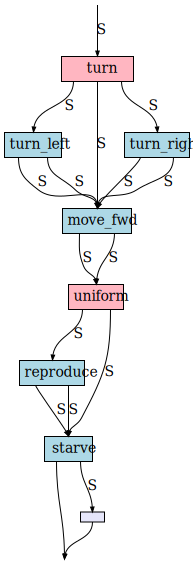

In [17]:

# Stuff that happens once per sheep 
#----------------------------------

# 25% chance of left turn, 25% chance of right turn, 50% stay in same direction
# 50% chance of reproducing
general = mk_sched((;),(init=:S,), (
  S = S, I = I, G = G,
  turn   = const_cond([1.,2.,1.], S; name=:turn), 
  maybe  = uniform(2, S), 
  lft    = sheep_rotate_l, 
  rght   = sheep_rotate_r, 
  fwd    = sheep_fwd, 
  repro  = sheep_reprod, 
  starve = sheep_starve), 
  quote 
    out_l, out_str, out_r = turn(init)
    moved = fwd([lft(out_l), out_str, rght(out_r)]) 
    out_repro, out_no_repro = maybe(moved)
    return starve([repro(out_repro), out_no_repro])
end)
view_sched(general; names=N)

The wolves and sheep differ in their eating rules, so we precompose the above common part of the day with their respective eating rules.

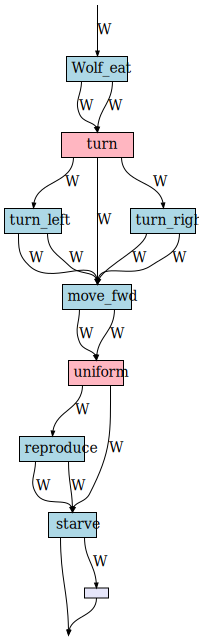

In [18]:
sheep = sheep_eat ⋅ general   # once per sheep
wolf = wolf_eat ⋅ Swap(general)  # once per wolf

view_sched(wolf; names=N)

The `agent` function creates a `Query` box and a subschedule and connects the second outport to the second inport, effectively executing the subschedule once per agent. We have subschedules for Sheep, Wolves, and Grass, so we compose these three agent actions in series.

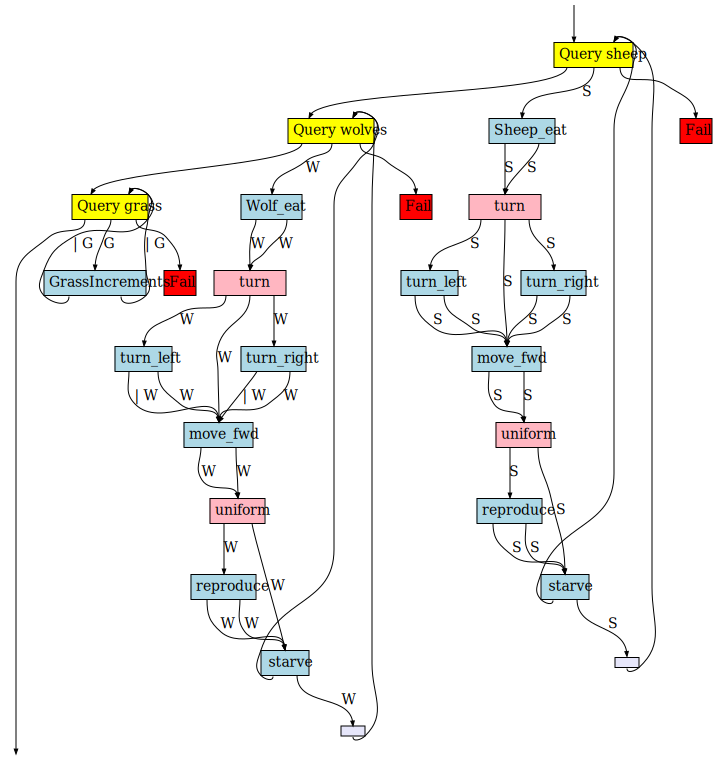

In [19]:
cycle = ( agent(sheep, S; n=:sheep,  ret=I)
        ⋅ agent(wolf,  W; n=:wolves, ret=I)
        ⋅ agent(g_inc, G; n=:grass))
view_sched(cycle; names=N)

Lastly we wrap the whole process in a `while` loop, and use the $\Sigma$ migration of `Coords` to lift the entire program into a setting where vertices have coordinates.

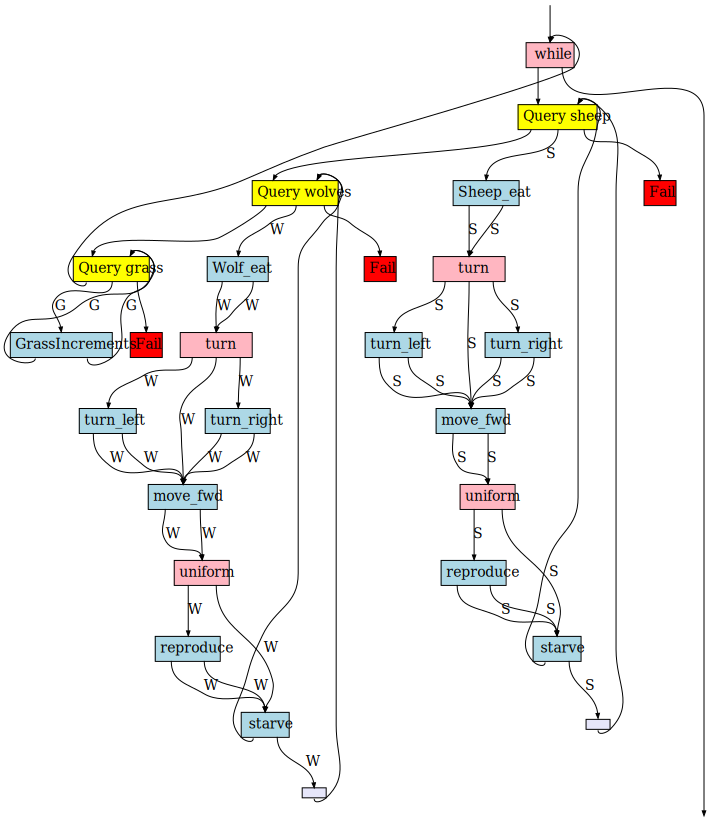

In [20]:
overall = while_schedule(cycle, curr -> nparts(curr,:Wolf) >= 0) |> Coords
view_sched(overall; names=Coords(N))

Now we can apply the program to `X` and view the results.

In [21]:
res, = apply_schedule(overall, X; steps=50);

And view the trajectory (the arrow $\rightarrow$ indicates that this wire has the "before" state, and the $\leftarrow$ indicates that this wire has the "after" state).

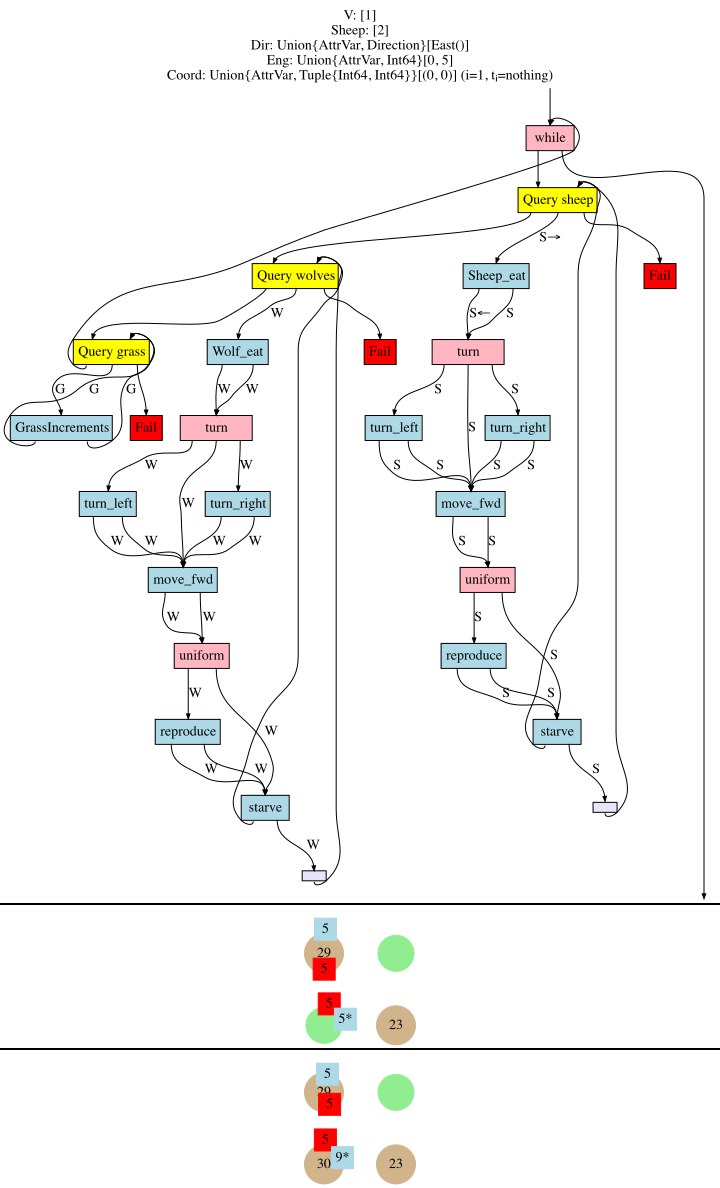

In [22]:
using Luxor
view_traj(overall, res, view_LV; agent=true, names=Coords(N))
readpng("traj/3.png")


# An example with Graphs
Here is another simulation that uses more varied features and is applied to graphs.

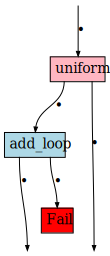

In [23]:
z, g1, ar = path_graph.(Graphs.Graph,0:2)
N=Dict(z=>"Z",g1=>"•",ar=>"•→•")

loop = apex(terminal(Graphs.Graph))
s_hom, t_hom = [ACSetTransformation(g1,ar; V=[i]) for i in 1:2]

al = succeed(RuleApp(:add_loop, Rule(id(g1), homomorphism(g1,loop)), g1))

q2 = Query(Span(t_hom,s_hom), :OutEdges, g1)
ws = Weaken(:Switch_to_src, s_hom)
wt = Weaken(:Switch_to_tgt, t_hom)
str = Strengthen(:Add_outedge, s_hom)
maybe_add_loop = uniform(2, g1) ⋅ (al ⊗ id([g1]))

view_sched(maybe_add_loop; names=N)


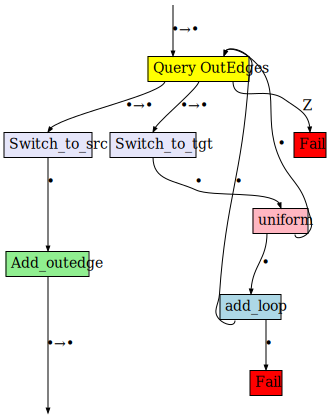

In [24]:

sched = mk_sched((trace_arg=:V,), (init=:A,), Dict(
  :loop => maybe_add_loop, :out_edges=>q2, :weaken_src=>ws, 
  :weaken_tgt=>wt, :add=>str, :A=>ar,:V=>g1, :Z=>z, :fail=>Fail(z)), 
quote 
  added_loops, out_edge, ignore = out_edges(init, trace_arg)
  fail(ignore)
  out_neighbor = weaken_tgt(out_edge)
  trace1, trace2 = loop(out_neighbor)
  out = add(weaken_src(added_loops))
  return [trace1, trace2], out
end);


view_sched(sched; names=N)



Thus, the overall simulation starts with a designated edge. It looks for all edges *out* of the target of the edge. For each of these, we focus on its target. We flip a coin and possibly add a loop to that vertex. After this is done, we focus on the *source* of our original edge. We simultaneously add a new vertex (and edge to that vertex) while making this new edge our focus as we exit the simulation.

In [25]:
function view_graph(a)
  g = codom(a)
  pg = to_graphviz_property_graph(g)
  for v in collect(a[:V])
    set_vprops!(pg, v, Dict([ :style=>"filled",:color=>"red",:fillcolor=>"red"]))
  end
  for e in collect(a[:E])
    set_eprops!(pg, e, Dict([:color=>"red"]))
  end
  return to_graphviz(pg)
end
G = @acset Graphs.Graph begin V=5; E=4; src=[1,2,2,5];tgt=[2,3,4,2] end 
arr_start = homomorphism(ar, G; initial=(V=[1,2],))
res, = apply_schedule(sched, arr_start);
view_traj(sched, res, view_graph; agent=true, names=N)


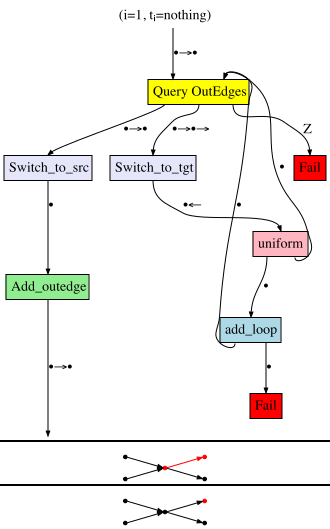

In [26]:
readpng("traj/5.png")

# Probabilistic simulation
This example showcases simulations in a probabilistic context.

For simplicity, we will use a color set that consists in simple Julia types, `Int` and `String` values, rather than the graph rewriting setting.

We define a box which probabilistically increments by two twice as likely as incrementing by one.
It has no state, which is the unit type `Nothing` in Julia.

```
      ---------
      |  inc  |- x+1 @ 1/3
x::ℕ -|       |- x+2 @ 2/3
      ---------
```

In [27]:
inc_fun(::Nothing,w::WireVal; kw...) = 
  MealyRes(nothing, [(p,WireVal(i,w.val+i)) for (i,p) in enumerate([1//3,2//3])])
mi = Mealy(inc_fun, Dist, nothing)

Mealy(inc_fun, PMonad(Int64, AlgebraicRewriting.Schedules.Poly.var"#11#12"(), AlgebraicRewriting.Schedules.Poly.joindist), nothing)

We also define a box that does have an internal (integer) state which is initially $5$ 
and decrements by 1 each time the box is run.
It returns "TIMEOUT" if the state is zero or lower, otherwise it checks if the state $S$ is odd. If so, it prints out two messages via the second output with weights $\frac{1}{3}$ and $\frac{2}{3}$, otherwise it sends out the new state on the first output.
```
     -----------------------
x::ℕ-|        S > 0 is even|- [S-1 @ 1]
    -| S::ℕ   S > 0 is odd |- ["x (or y) 1/3" @ 1/3, "x (or y) 2/3" @ 2/3]
     -----------------------

```

In [28]:
function some_fun(S::Int,w::WireVal; kw...)  
  if S <= 0 return MealyRes(S, [(1,WireVal(2, "TIMEOUT"))])
  elseif w.val % 2 == 0 return MealyRes(S-1,[(1,WireVal(1,w.val))])
    else return MealyRes(S,[(p,WireVal(2, "$(w.val) $p")) for p in [1//3,2//3]])
  end
end
ms = Mealy(some_fun, Dist, 5)


Mealy(some_fun, PMonad(Int64, AlgebraicRewriting.Schedules.Poly.var"#11#12"(), AlgebraicRewriting.Schedules.Poly.joindist), 5)

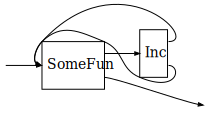

In [29]:
using Catlab.WiringDiagrams, Catlab.Graphics

wd = WiringDiagram([:N],[:S])
b1 = add_box!(wd, Box("SomeFun",[:N],[:N,:S]))
b2 = add_box!(wd, Box("Inc",[:N],[:N,:N]))
i, o = [(f(wd),1) for f in [input_id, output_id]]
add_wires!(wd, Pair[i=>(b1,1), (b1,1)=>(b2,1), (b1,2)=>o, (b2,1)=>(b1,1),(b2,2)=>(b1,1)])

to_graphviz(wd; orientation=LeftToRight)

In [30]:
wd.diagram[:box_type] = Box{Mealy}
wd.diagram[:value] = [ms,mi]
res, = apply_schedule(wd, 0, Dist)

@test sum([r[1] for r in res]) == 1
@test res[10][2].steps[end].edge.o.val == "TIMEOUT"

Test Passed